# Static analysis of the trial dataset

Following section shows an example of the contents of the trial dataset.
Please note that the competitors may not get sensor data in this batch-like form in the scoring trials.
This notebook is for understanding what will be available during the competition.


## Sensor data
Following sections reads and plots sensor data for estimation.

### File format
Our dataset complies with the format provided by LOPSI, CAR-CSIC.
```
% LogFile Data format:
% Accelerometer data: 	'ACCE;AppTimestamp(s);SensorTimestamp(s);Acc_X(m/s^2);Acc_Y(m/s^2);Acc_Z(m/s^2);Accuracy(integer)'
% Gyroscope data:     	'GYRO;AppTimestamp(s);SensorTimestamp(s);Gyr_X(rad/s);Gyr_Y(rad/s);Gyr_Z(rad/s);Accuracy(integer)'
% Magnetometer data:  	'MAGN;AppTimestamp(s);SensorTimestamp(s);Mag_X(uT);;Mag_Y(uT);Mag_Z(uT);Accuracy(integer)'
% Orientation data:   	'AHRS;AppTimestamp(s);SensorTimestamp(s);PitchX(deg);RollY(deg);YawZ(deg);Quat(2);Quat(3);Quat(4);Accuracy(int)'
% 
% Note that there are two timestamps: 
%  -'AppTimestamp' is set by the Android App as data is read. It is not representative of when data is actually captured by the sensor (but has a common time reference for all sensors)
%  -'SensorTimestamp' is set by the sensor itself (the delta_time=SensorTimestamp(k)-SensorTimestamp(k-1) between two consecutive samples is an accurate estimate of the sampling interval). This timestamp is better for integrating inertial data. 
```

Additionally, our dataset contains following lines
```
Visual inertial odometry data:   	'VISO;AppTimestamp(s);SensorTimestamp(s);Location_X(m);Location_Y(m);Location_Z(m);Quat(X);Quat(Y);Quat(Z)'
UWB ranging data (phone-side):   	'UWBP;AppTimestamp(s);SensorTimestamp(s);tag_id;distance(m);direction_vec(X);direction_vec(Y);direction_vec(Z)'
UWB ranging data (tag-side):   	'UWBT;AppTimestamp(s);SensorTimestamp(s);tag_id;distance(m);aoa_azimuth(deg);aoa_elevation(deg);nlos(binary)'
Pose of a stuff in global frame data: 'GPOS;AppTimestamp(s);SensorTimestamp(s);ID_of_stuff;Location_X(m);Location_Y(m);Location_Z(m);Quat(X);Quat(Y);Quat(Z)'
```

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_name = "1"

### Read the sensor data

In [3]:
# Step 1: Read the file and organize data by sensor type
def read_sensor_file(file_path):
    # Dictionary to store data for each sensor type
    sensor_data = {}
    
    # Open and read the file
    with open(file_path, 'r') as file:
        for line in file:
            # Skip empty lines
            if not line.strip():
                continue
            
            # Split the line by semicolon
            parts = line.strip().split(';')
            
            # Get sensor type (first part of the line)
            sensor_type = parts[0]
            
            # Initialize list for this sensor type if not already in dictionary
            if sensor_type not in sensor_data:
                sensor_data[sensor_type] = []
            
            # Add the data (without the sensor type) to the list
            sensor_data[sensor_type].append(parts[1:])
    
    return sensor_data

# Step 2: Convert data to pandas DataFrames
def create_dataframes(sensor_data):
    # Dictionary to store dataframes
    dataframes = {}
    
    # Column names for each sensor type
    columns = {
        'ACCE': ['app_timestamp', 'sensor_timestamp', 'acc_x', 'acc_y', 'acc_z', 'accuracy'],
        'GYRO': ['app_timestamp', 'sensor_timestamp', 'gyr_x', 'gyr_y', 'gyr_z', 'accuracy'],
        'MAGN': ['app_timestamp', 'sensor_timestamp', 'mag_x', 'mag_y', 'mag_z', 'accuracy'],
        'AHRS': ['app_timestamp', 'sensor_timestamp', 'pitch_x', 'roll_y', 'yaw_z', 'quat_2', 'quat_3', 'quat_4', 'accuracy'],
        'UWBP': ['app_timestamp', 'sensor_timestamp', 'tag_id', 'distance', 'direction_vec_x', 'direction_vec_y', 'direction_vec_z'],
        'UWBT': ['app_timestamp', 'sensor_timestamp', 'tag_id', 'distance', 'aoa_azimuth', 'aoa_elevation', 'nlos'],
        'GPOS': ['app_timestamp', 'sensor_timestamp', 'object_id', 'location_x', 'location_y', 'location_z', 'quat_x', 'quat_y', 'quat_z'],
        'VISO': ['app_timestamp', 'sensor_timestamp', 'location_x', 'location_y', 'location_z', 'quat_x', 'quat_y', 'quat_z']
    }
    
    # Create a dataframe for each sensor type
    for sensor_type, data in sensor_data.items():
        if sensor_type in columns:
            # Create a dataframe with the appropriate column names
            df = pd.DataFrame(data, columns=columns[sensor_type])
            
            # Convert numeric columns from strings to floats
            for col in df.columns:
                if col not in ['tag_id', 'object_id']:  # Skip non-numeric columns
                    df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Use sensor_timestamp as the index
            df.set_index('sensor_timestamp', inplace=True)
            
            # Store the dataframe
            dataframes[sensor_type] = df
    
    return dataframes


# File path
file_path = f'./evaalapi_server/trials/{data_name}.txt'  # Update this path if your file is in a different location

# Step 1: Read the file
print("Reading sensor data file...")
sensor_data = read_sensor_file(file_path)

# Step 2: Create dataframes
print("Creating dataframes...")
dataframes = create_dataframes(sensor_data)


Reading sensor data file...
Creating dataframes...


### ACCE : ACCElerometer


Plotting ACCE data...


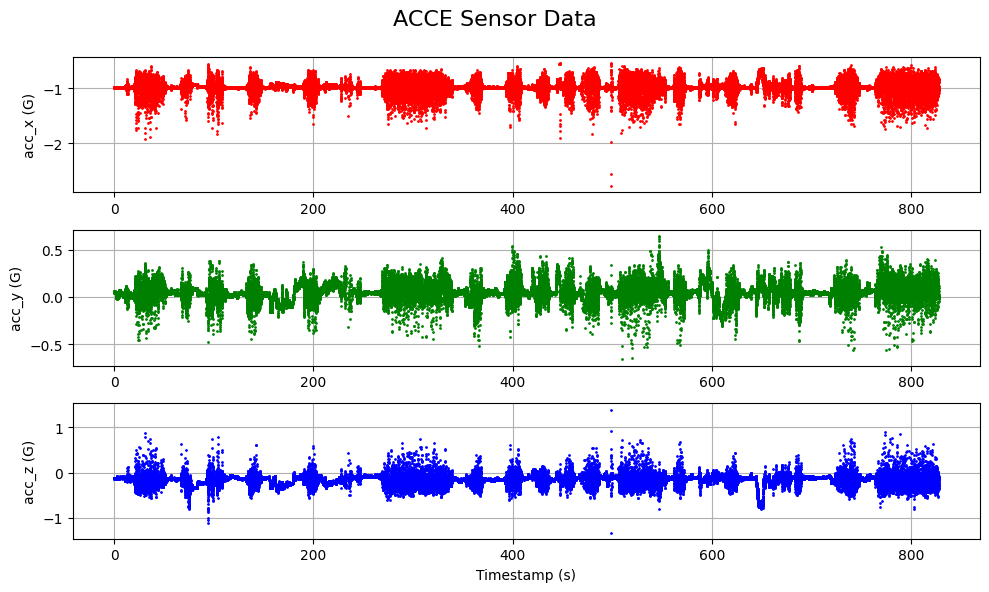

Plotting ACCE sampling frequency histogram...


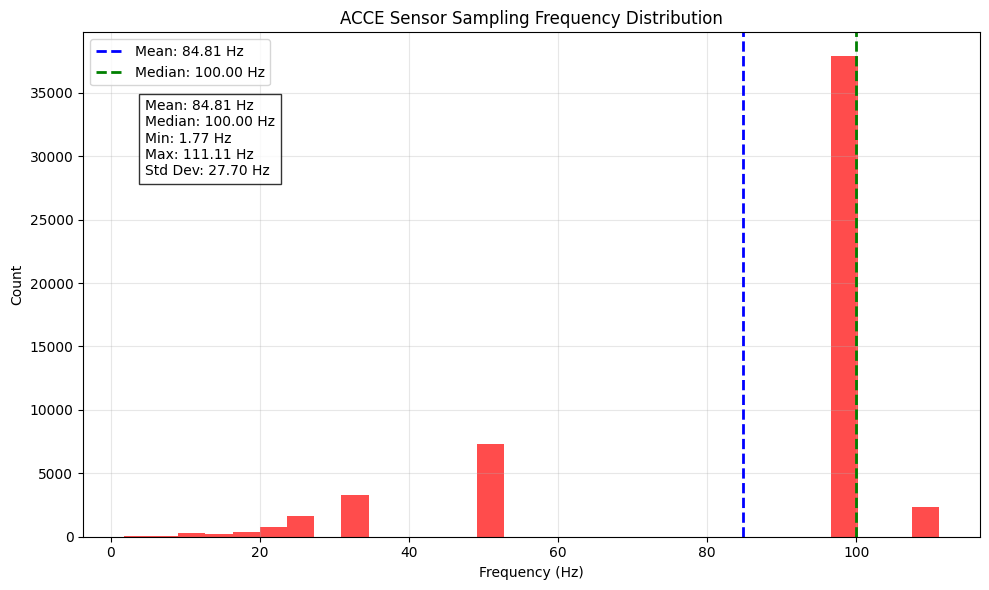

In [4]:

# Step 3: Individual plot functions for each sensor type

# Plot ACCE sensor data
def plot_acce_data(df):
    print("Plotting ACCE data...")
    
    columns_to_plot = ['acc_x', 'acc_y', 'acc_z']
    
    fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 2*len(columns_to_plot)))
    fig.suptitle('ACCE Sensor Data', fontsize=16)
    
    axes[0].plot(df.index, df['acc_x'], 'o', markersize=1.0, color='red')
    axes[0].set_ylabel('acc_x (G)')
    axes[0].grid(True)
    
    axes[1].plot(df.index, df['acc_y'], 'o', markersize=1.0, color='green')
    axes[1].set_ylabel('acc_y (G)')
    axes[1].grid(True)
    
    axes[2].plot(df.index, df['acc_z'], 'o', markersize=1.0, color='blue')
    axes[2].set_ylabel('acc_z (G)')
    axes[2].grid(True)
    
    axes[-1].set_xlabel('Timestamp (s)')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    
def calculate_frequencies(timestamps):
    timestamps = timestamps.astype(float)
    time_diffs = np.diff(timestamps)
    frequencies = 1.0 / time_diffs
    if len(frequencies) > 0:
        mean_freq = np.mean(frequencies)
        std_freq = np.std(frequencies)
        filtered_freqs = frequencies[np.abs(frequencies - mean_freq) <= 3 * std_freq]
        return filtered_freqs
    return np.array([])

    
def plot_acce_frequency(df):
    print("Plotting ACCE sampling frequency histogram...")
    
    # Calculate frequencies
    frequencies = calculate_frequencies(df.index)
    
    if len(frequencies) == 0:
        print("  No frequency data for ACCE")
        return
    
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(frequencies, bins=30, alpha=0.7, color='red')
    plt.title('ACCE Sensor Sampling Frequency Distribution')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    
    # Add statistical information
    plt.axvline(np.mean(frequencies), color='blue', linestyle='dashed', 
                linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
    plt.axvline(np.median(frequencies), color='green', linestyle='dashed', 
                linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
    plt.legend()
    
    # Add text with statistics
    stats_text = f"Mean: {np.mean(frequencies):.2f} Hz\n"
    stats_text += f"Median: {np.median(frequencies):.2f} Hz\n"
    stats_text += f"Min: {np.min(frequencies):.2f} Hz\n"
    stats_text += f"Max: {np.max(frequencies):.2f} Hz\n"
    stats_text += f"Std Dev: {np.std(frequencies):.2f} Hz"
    
    plt.figtext(0.15, 0.7, stats_text, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

plot_acce_data(dataframes['ACCE'])
plot_acce_frequency(dataframes['ACCE'])
    

### GYRO : GYROscope

Plotting GYRO data...


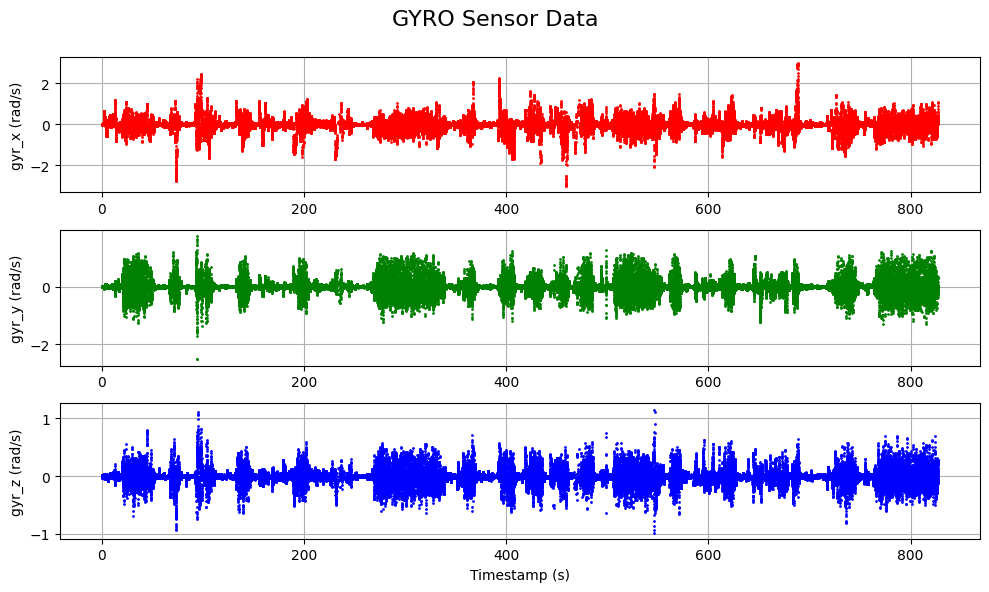

Plotting GYRO sampling frequency histogram...


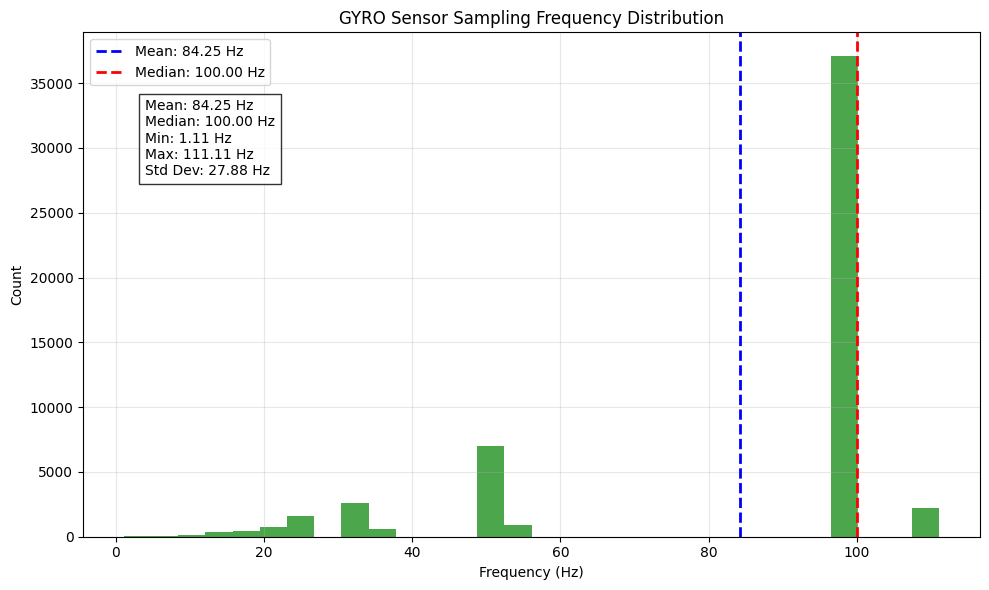

In [5]:
def plot_gyro_data(df):
    print("Plotting GYRO data...")
    
    columns_to_plot = ['gyr_x', 'gyr_y', 'gyr_z']
    
    fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 2*len(columns_to_plot)))
    fig.suptitle('GYRO Sensor Data', fontsize=16)
    
    axes[0].plot(df.index, df['gyr_x'], 'o', markersize=1.0, color='red')
    axes[0].set_ylabel('gyr_x (rad/s)')
    axes[0].grid(True)
    
    axes[1].plot(df.index, df['gyr_y'], 'o', markersize=1.0, color='green')
    axes[1].set_ylabel('gyr_y (rad/s)')
    axes[1].grid(True)
    
    axes[2].plot(df.index, df['gyr_z'], 'o', markersize=1.0, color='blue')
    axes[2].set_ylabel('gyr_z (rad/s)')
    axes[2].grid(True)
    
    axes[-1].set_xlabel('Timestamp (s)')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    
# Plot histogram for GYRO sampling frequency
def plot_gyro_frequency(df):
    print("Plotting GYRO sampling frequency histogram...")
    
    # Calculate frequencies
    frequencies = calculate_frequencies(df.index)
    
    if len(frequencies) == 0:
        print("  No frequency data for GYRO")
        return
    
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(frequencies, bins=30, alpha=0.7, color='green')
    plt.title('GYRO Sensor Sampling Frequency Distribution')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    
    # Add statistical information
    plt.axvline(np.mean(frequencies), color='blue', linestyle='dashed', 
                linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
    plt.axvline(np.median(frequencies), color='red', linestyle='dashed', 
                linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
    plt.legend()
    
    # Add text with statistics
    stats_text = f"Mean: {np.mean(frequencies):.2f} Hz\n"
    stats_text += f"Median: {np.median(frequencies):.2f} Hz\n"
    stats_text += f"Min: {np.min(frequencies):.2f} Hz\n"
    stats_text += f"Max: {np.max(frequencies):.2f} Hz\n"
    stats_text += f"Std Dev: {np.std(frequencies):.2f} Hz"
    
    plt.figtext(0.15, 0.7, stats_text, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    
plot_gyro_data(dataframes['GYRO'])
    
plot_gyro_frequency(dataframes['GYRO'])

### MAGN : MAGNetometer

Plotting MAGN data...


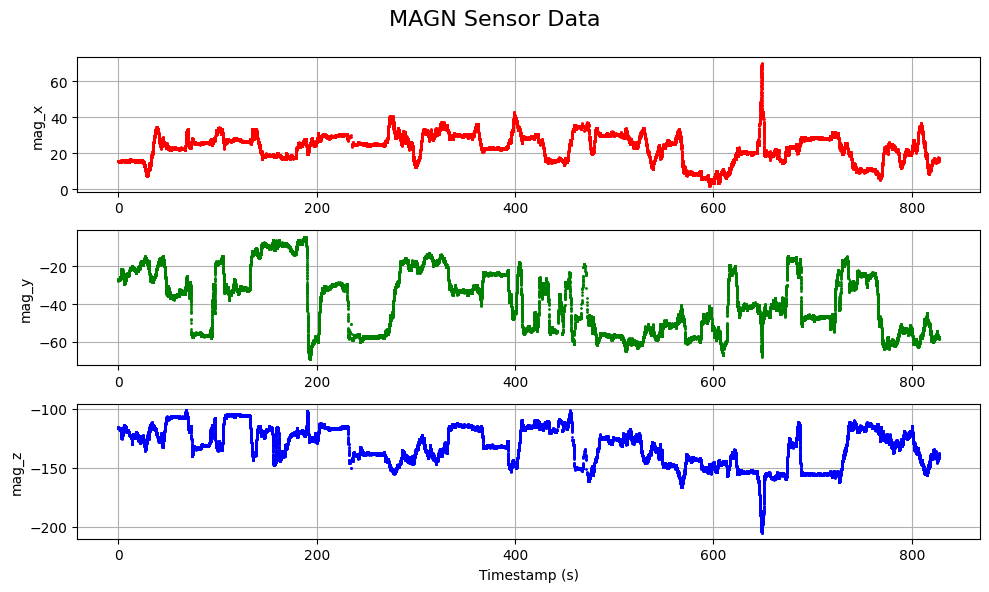

Plotting MAGN sampling frequency histogram...


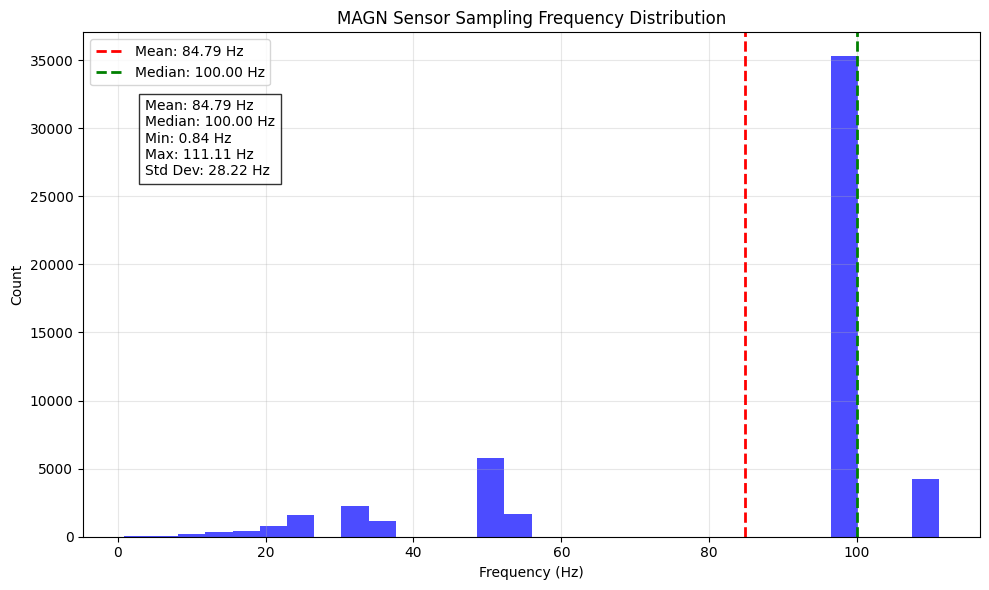

In [6]:
def plot_magn_data(df):
    print("Plotting MAGN data...")
    
    columns_to_plot = ['mag_x', 'mag_y', 'mag_z']
    
    fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 2*len(columns_to_plot)))
    fig.suptitle('MAGN Sensor Data', fontsize=16)
    
    axes[0].plot(df.index, df['mag_x'], 'o', markersize=1.0, color='red')
    axes[0].set_ylabel('mag_x')
    axes[0].grid(True)
    
    axes[1].plot(df.index, df['mag_y'], 'o', markersize=1.0, color='green')
    axes[1].set_ylabel('mag_y')
    axes[1].grid(True)
    
    axes[2].plot(df.index, df['mag_z'], 'o', markersize=1.0, color='blue')
    axes[2].set_ylabel('mag_z')
    axes[2].grid(True)
    
    axes[-1].set_xlabel('Timestamp (s)')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    
    # Plot histogram for MAGN sampling frequency
def plot_magn_frequency(df):
    print("Plotting MAGN sampling frequency histogram...")
    
    # Calculate frequencies
    frequencies = calculate_frequencies(df.index)
    
    if len(frequencies) == 0:
        print("  No frequency data for MAGN")
        return
    
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(frequencies, bins=30, alpha=0.7, color='blue')
    plt.title('MAGN Sensor Sampling Frequency Distribution')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    
    # Add statistical information
    plt.axvline(np.mean(frequencies), color='red', linestyle='dashed', 
                linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
    plt.axvline(np.median(frequencies), color='green', linestyle='dashed', 
                linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
    plt.legend()
    
    # Add text with statistics
    stats_text = f"Mean: {np.mean(frequencies):.2f} Hz\n"
    stats_text += f"Median: {np.median(frequencies):.2f} Hz\n"
    stats_text += f"Min: {np.min(frequencies):.2f} Hz\n"
    stats_text += f"Max: {np.max(frequencies):.2f} Hz\n"
    stats_text += f"Std Dev: {np.std(frequencies):.2f} Hz"
    
    plt.figtext(0.15, 0.7, stats_text, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    

plot_magn_data(dataframes['MAGN'])
plot_magn_frequency(dataframes['MAGN'])


### AHRS : Attitude And Heading Reference

Plotting AHRS data...


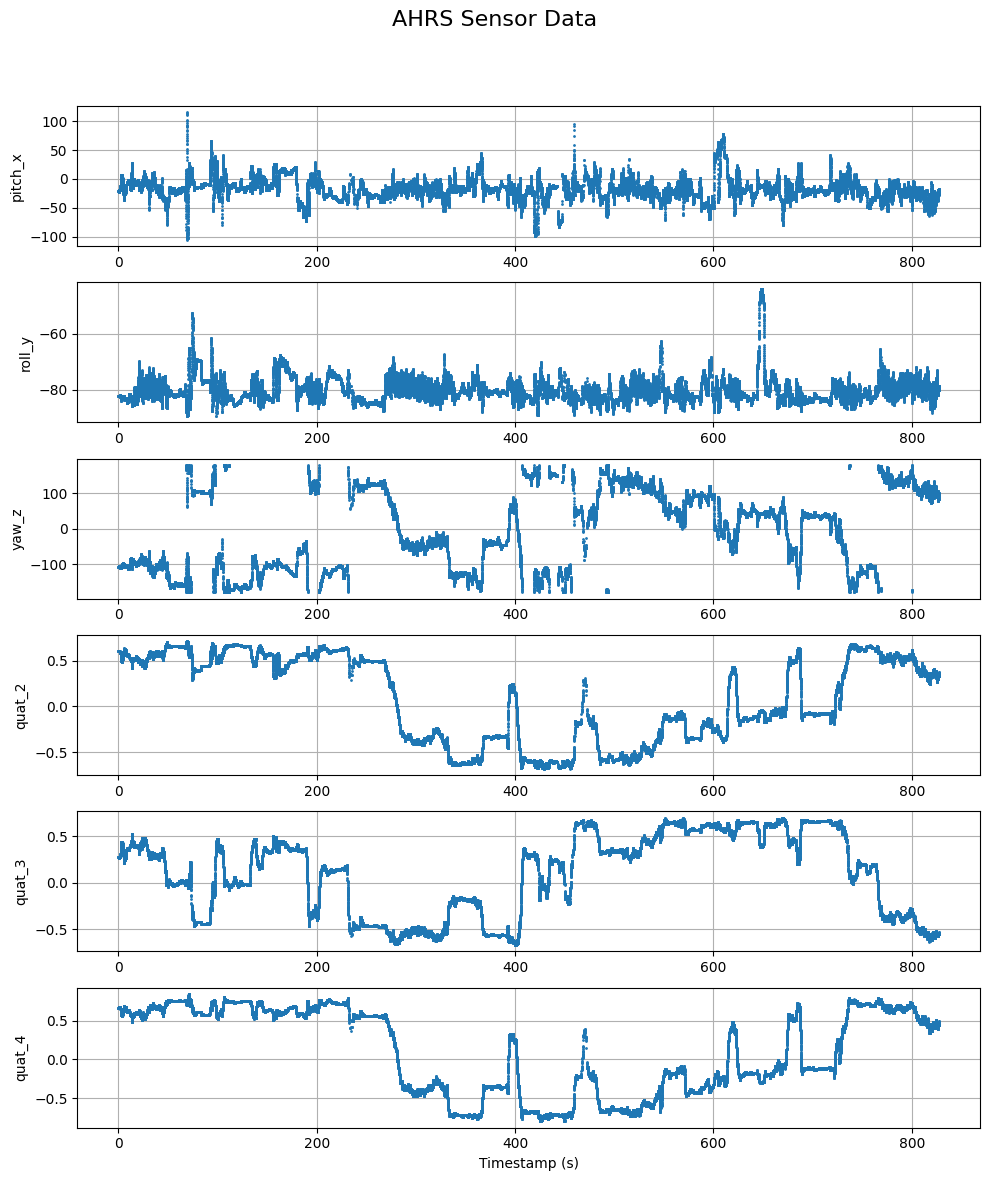

Plotting AHRS sampling frequency histogram...


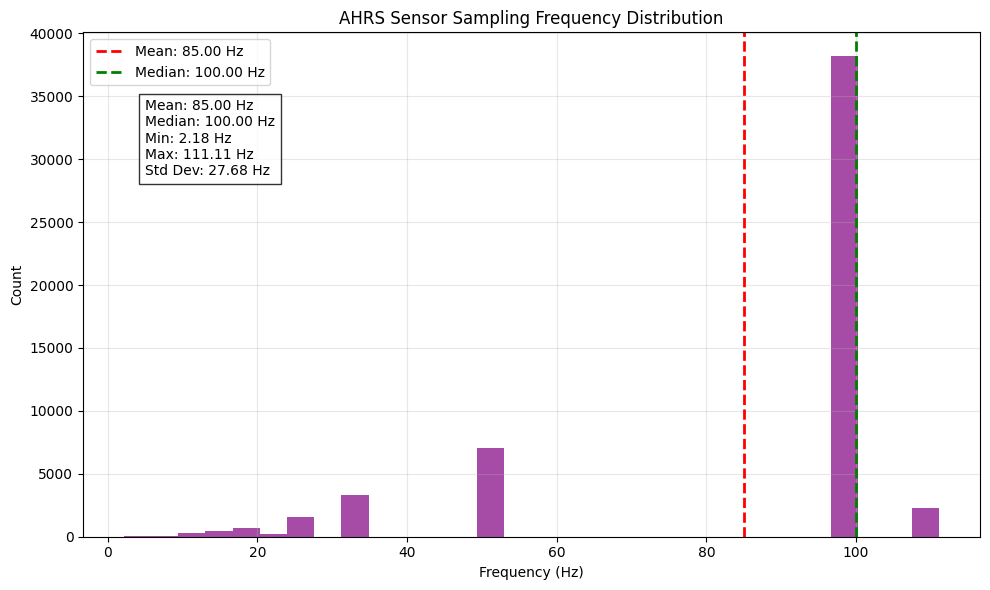

In [7]:
def plot_ahrs_data(df):
    print("Plotting AHRS data...")
    
    columns_to_plot = ['pitch_x', 'roll_y', 'yaw_z', 'quat_2', 'quat_3', 'quat_4']
    
    fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 2*len(columns_to_plot)))
    fig.suptitle('AHRS Sensor Data', fontsize=16)
    
    axes[0].plot(df.index, df['pitch_x'], 'o', markersize=1.0)
    axes[0].set_ylabel('pitch_x')
    axes[0].grid(True)
    
    axes[1].plot(df.index, df['roll_y'], 'o', markersize=1.0)
    axes[1].set_ylabel('roll_y')
    axes[1].grid(True)
    
    axes[2].plot(df.index, df['yaw_z'], 'o', markersize=1.0)
    axes[2].set_ylabel('yaw_z')
    axes[2].grid(True)
    
    axes[3].plot(df.index, df['quat_2'], 'o', markersize=1.0)
    axes[3].set_ylabel('quat_2')
    axes[3].grid(True)
    
    axes[4].plot(df.index, df['quat_3'], 'o', markersize=1.0)
    axes[4].set_ylabel('quat_3')
    axes[4].grid(True)
    
    axes[5].plot(df.index, df['quat_4'], 'o', markersize=1.0)
    axes[5].set_ylabel('quat_4')
    axes[5].grid(True)
    
    axes[-1].set_xlabel('Timestamp (s)')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    
def plot_ahrs_frequency(df):
    print("Plotting AHRS sampling frequency histogram...")
    
    # Calculate frequencies
    frequencies = calculate_frequencies(df.index)
    
    if len(frequencies) == 0:
        print("  No frequency data for AHRS")
        return
    
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(frequencies, bins=30, alpha=0.7, color='purple')
    plt.title('AHRS Sensor Sampling Frequency Distribution')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    
    # Add statistical information
    plt.axvline(np.mean(frequencies), color='red', linestyle='dashed', 
                linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
    plt.axvline(np.median(frequencies), color='green', linestyle='dashed', 
                linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
    plt.legend()
    
    # Add text with statistics
    stats_text = f"Mean: {np.mean(frequencies):.2f} Hz\n"
    stats_text += f"Median: {np.median(frequencies):.2f} Hz\n"
    stats_text += f"Min: {np.min(frequencies):.2f} Hz\n"
    stats_text += f"Max: {np.max(frequencies):.2f} Hz\n"
    stats_text += f"Std Dev: {np.std(frequencies):.2f} Hz"
    
    plt.figtext(0.15, 0.7, stats_text, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    
plot_ahrs_data(dataframes['AHRS'])
plot_ahrs_frequency(dataframes['AHRS'])


### UWBP: UWB Phone-side data

Plotting UWBP data...
  Creating plot for tag_id=3637RLJ...


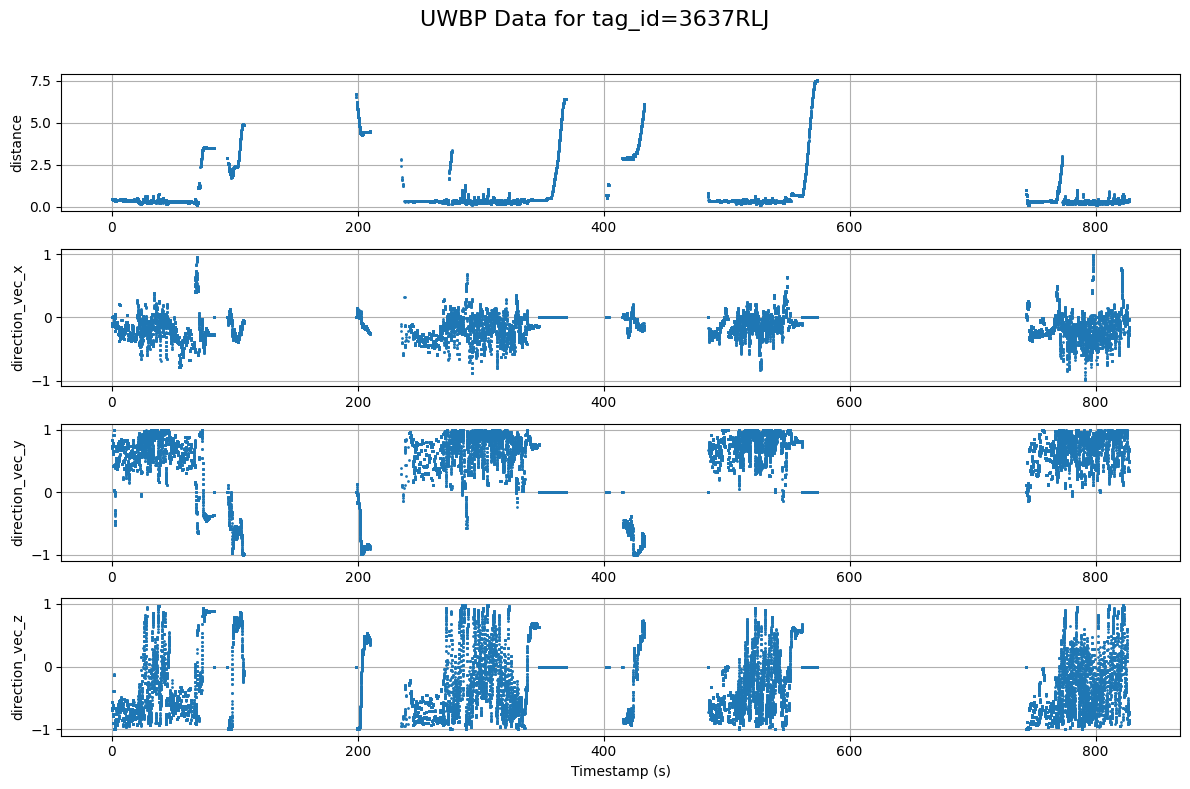

  Creating plot for tag_id=3636DWF...


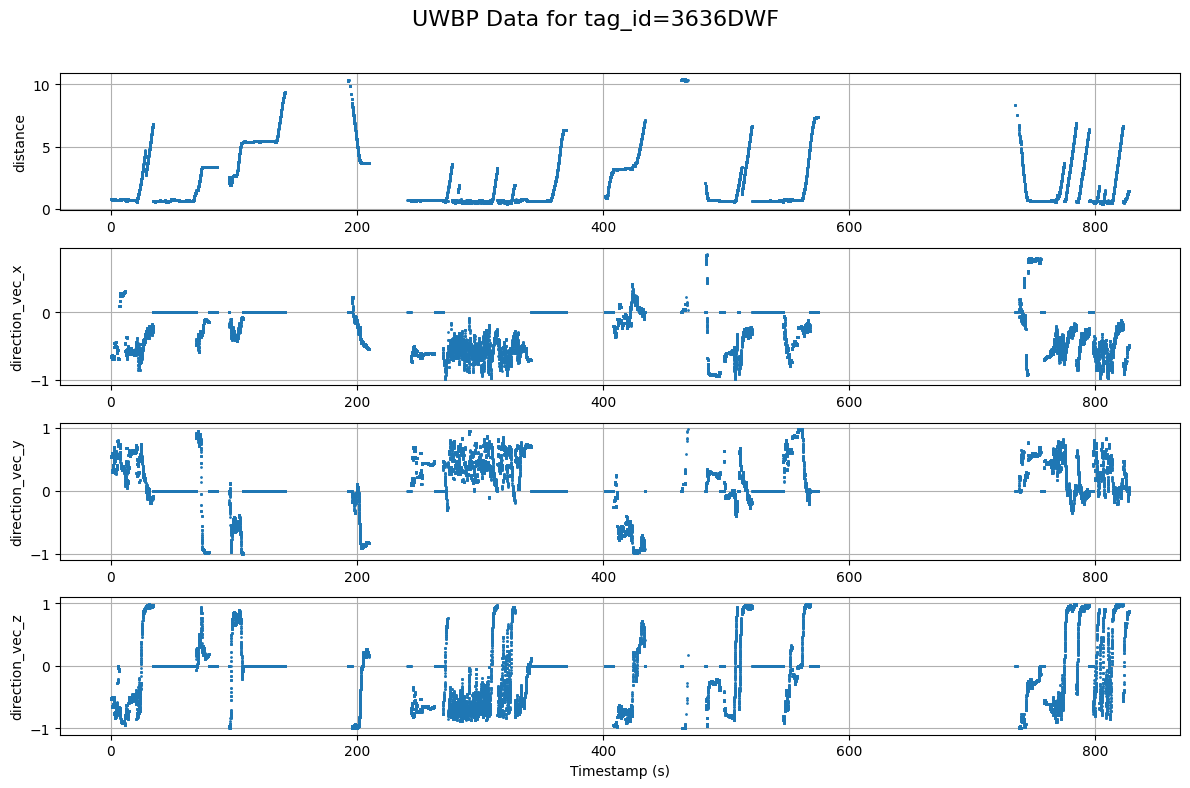

  Creating plot for tag_id=3583WAA...


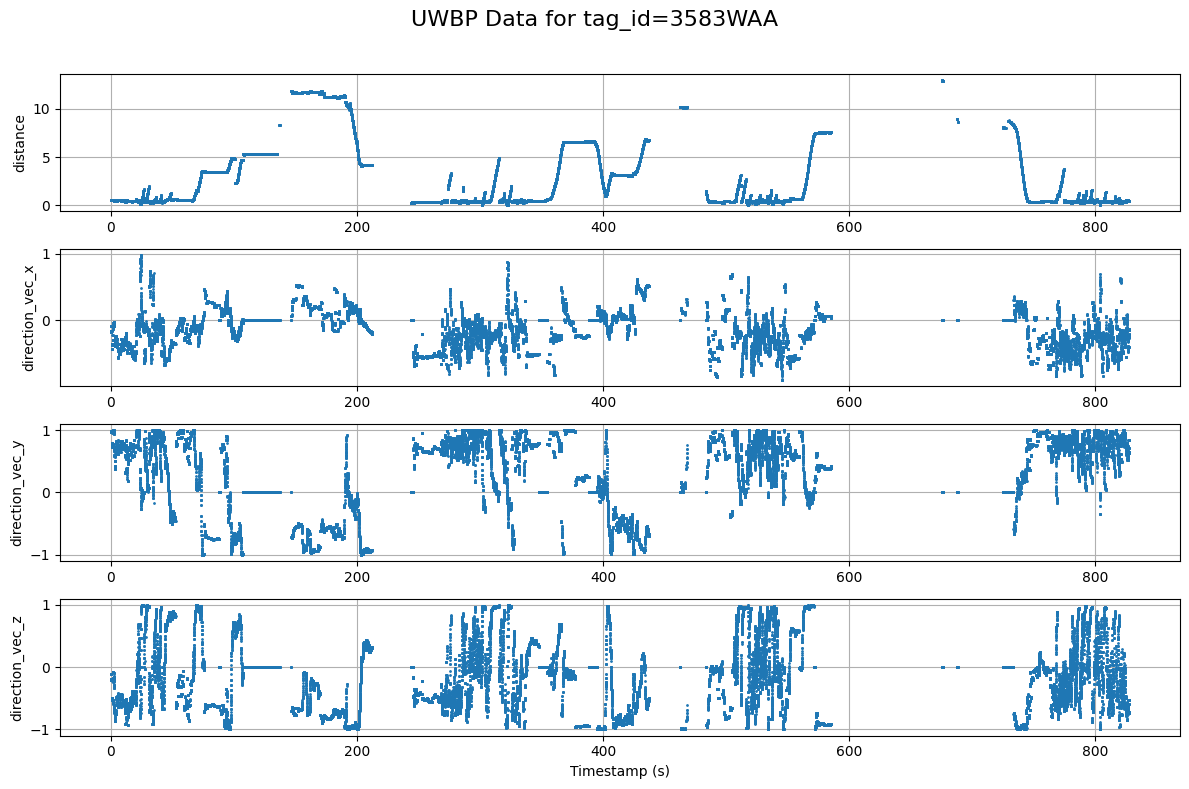

Plotting UWBP sampling frequency histogram...
  Creating frequency histogram for tag_id=3637RLJ...
  No frequency data for UWBP with tag_id=3637RLJ
  Creating frequency histogram for tag_id=3636DWF...
  No frequency data for UWBP with tag_id=3636DWF
  Creating frequency histogram for tag_id=3583WAA...
  No frequency data for UWBP with tag_id=3583WAA


/var/folders/_h/blz30qzs68vf6ql82rllw6b00000gn/T/ipykernel_96928/1497721031.py:34: RuntimeWarning: divide by zero encountered in divide
  frequencies = 1.0 / time_diffs
/Users/ogiso/.pyenv/versions/3.9.16/envs/localization-3.9/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/var/folders/_h/blz30qzs68vf6ql82rllw6b00000gn/T/ipykernel_96928/1497721031.py:38: RuntimeWarning: invalid value encountered in subtract
  filtered_freqs = frequencies[np.abs(frequencies - mean_freq) <= 3 * std_freq]
/var/folders/_h/blz30qzs68vf6ql82rllw6b00000gn/T/ipykernel_96928/1497721031.py:34: RuntimeWarning: divide by zero encountered in divide
  frequencies = 1.0 / time_diffs
/Users/ogiso/.pyenv/versions/3.9.16/envs/localization-3.9/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/var/folders/_h/blz30qzs68vf6ql82rllw6b00000g

In [8]:
def plot_uwbp_data(df):
    print("Plotting UWBP data...")
    
    # Get unique tag_ids
    unique_tags = df['tag_id'].unique()
    
    for tag_id in unique_tags:
        print(f"  Creating plot for tag_id={tag_id}...")
        
        # Filter data for this tag_id
        tag_df = df[df['tag_id'] == tag_id]
        
        columns_to_plot = ['distance', 'direction_vec_x', 'direction_vec_y', 'direction_vec_z']
        
        fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(12, 2*len(columns_to_plot)))
        fig.suptitle(f'UWBP Data for tag_id={tag_id}', fontsize=16)
        
        axes[0].plot(tag_df.index, tag_df['distance'], 'o', markersize=1.0)
        axes[0].set_ylabel('distance')
        axes[0].grid(True)
        
        axes[1].plot(tag_df.index, tag_df['direction_vec_x'], 'o', markersize=1.0)
        axes[1].set_ylabel('direction_vec_x')
        axes[1].grid(True)
        
        axes[2].plot(tag_df.index, tag_df['direction_vec_y'], 'o', markersize=1.0)
        axes[2].set_ylabel('direction_vec_y')
        axes[2].grid(True)
        
        axes[3].plot(tag_df.index, tag_df['direction_vec_z'], 'o', markersize=1.0)
        axes[3].set_ylabel('direction_vec_z')
        axes[3].grid(True)
        
        axes[-1].set_xlabel('Timestamp (s)')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
        


def plot_uwbp_frequency(df):
    print("Plotting UWBP sampling frequency histogram...")
    
    # Get unique tag_ids
    unique_tags = df['tag_id'].unique()
    
    for tag_id in unique_tags:
        print(f"  Creating frequency histogram for tag_id={tag_id}...")
        
        # Filter data for this tag_id
        tag_df = df[df['tag_id'] == tag_id]
        
        # Calculate frequencies
        frequencies = calculate_frequencies(tag_df.index)
        
        if len(frequencies) == 0:
            print(f"  No frequency data for UWBP with tag_id={tag_id}")
            continue
        
        # Create the histogram
        plt.figure(figsize=(10, 6))
        plt.hist(frequencies, bins=30, alpha=0.7, color='orange')
        plt.title(f'UWBP Sensor Sampling Frequency Distribution - Tag ID: {tag_id}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)
        
        # Add statistical information
        plt.axvline(np.mean(frequencies), color='red', linestyle='dashed', 
                    linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
        plt.axvline(np.median(frequencies), color='green', linestyle='dashed', 
                    linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
        plt.legend()
        
        # Add text with statistics
        stats_text = f"Mean: {np.mean(frequencies):.2f} Hz\n"
        stats_text += f"Median: {np.median(frequencies):.2f} Hz\n"
        stats_text += f"Min: {np.min(frequencies):.2f} Hz\n"
        stats_text += f"Max: {np.max(frequencies):.2f} Hz\n"
        stats_text += f"Std Dev: {np.std(frequencies):.2f} Hz"
        
        plt.figtext(0.15, 0.7, stats_text, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()        


plot_uwbp_data(dataframes['UWBP'])
plot_uwbp_frequency(dataframes['UWBP'])
    

### UWBT : UWB Tag-side data

Plotting UWBT data...
  Creating plot for tag_id=3637RLJ...


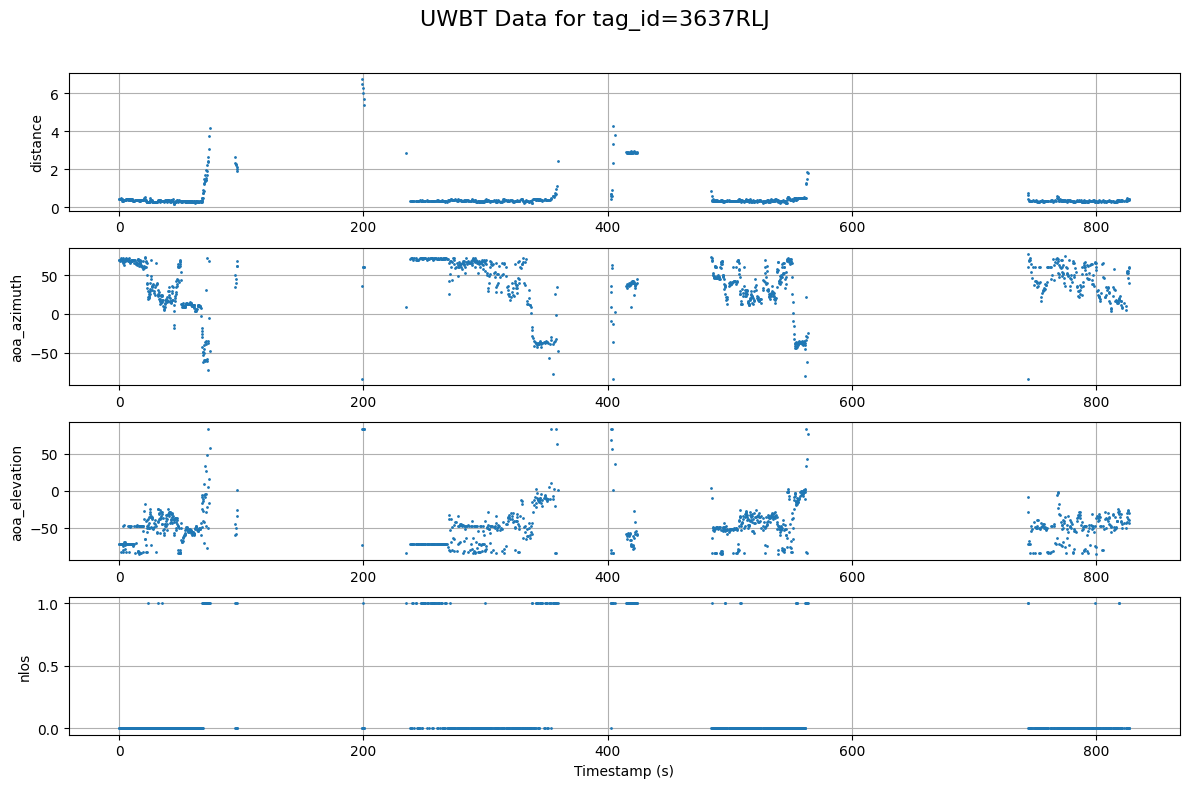

  Creating plot for tag_id=3583WAA...


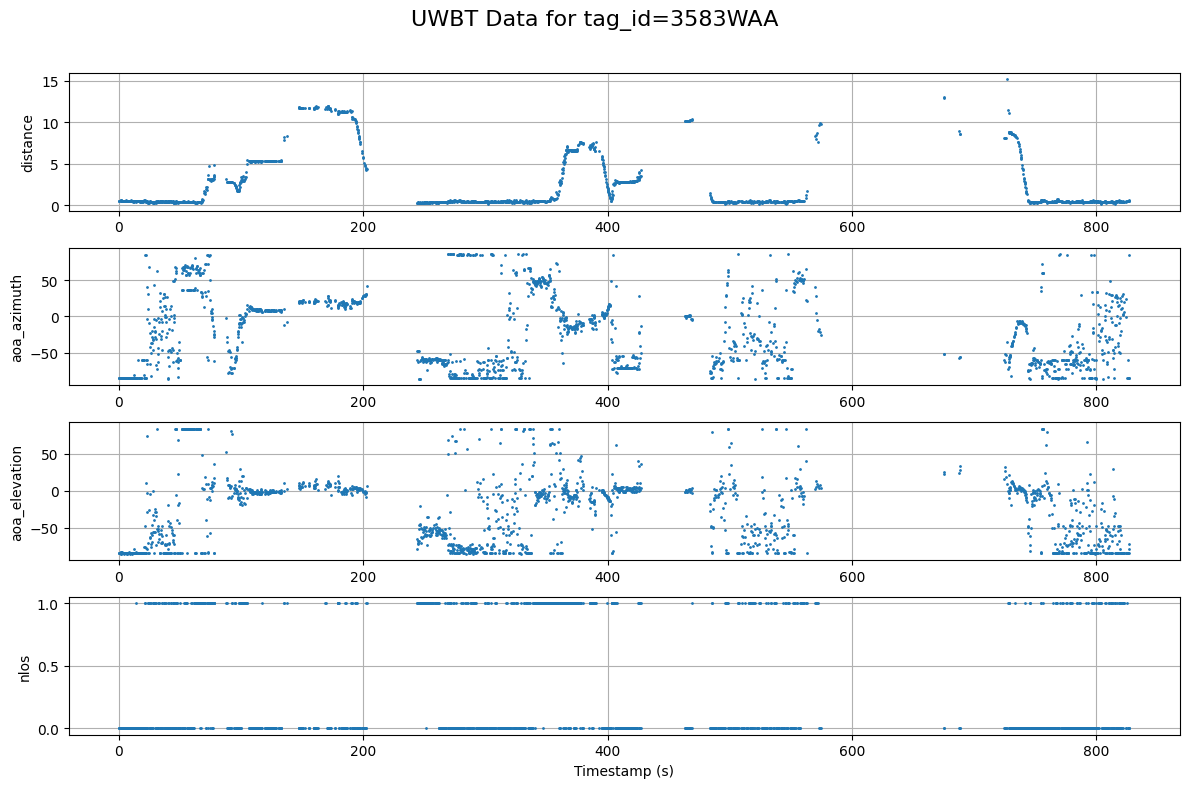

  Creating plot for tag_id=3636DWF...


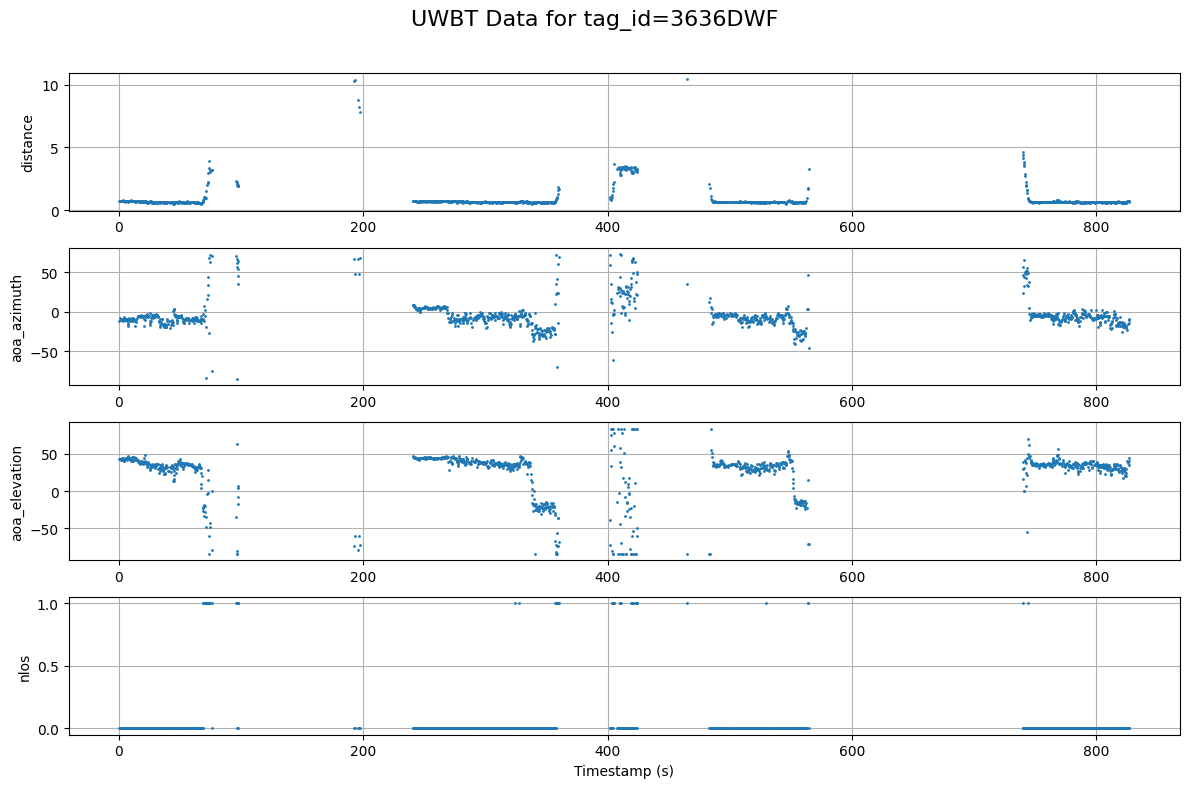

Plotting UWBT sampling frequency histogram...
  Creating frequency histogram for tag_id=3637RLJ...


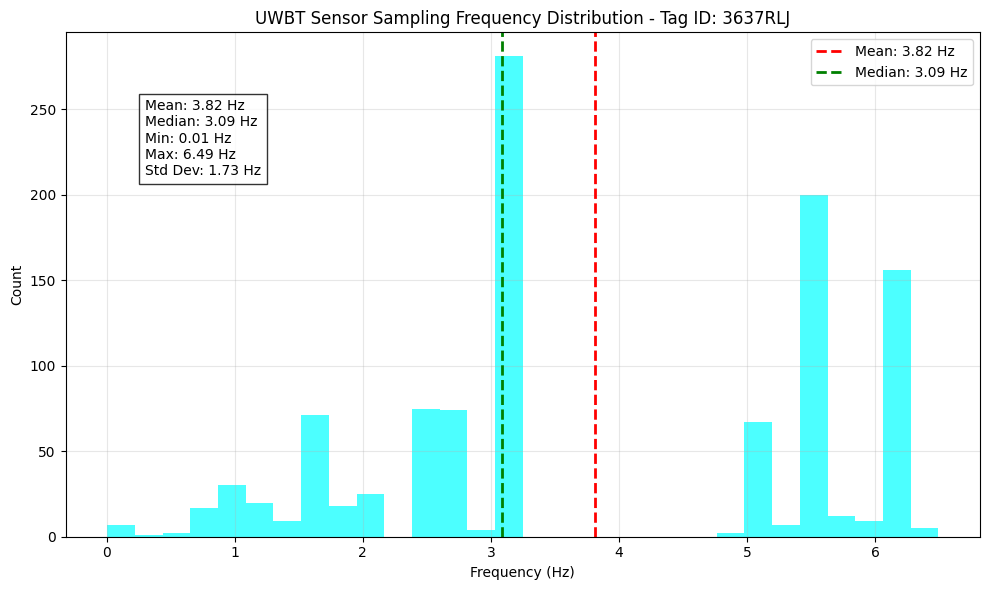

  Creating frequency histogram for tag_id=3583WAA...


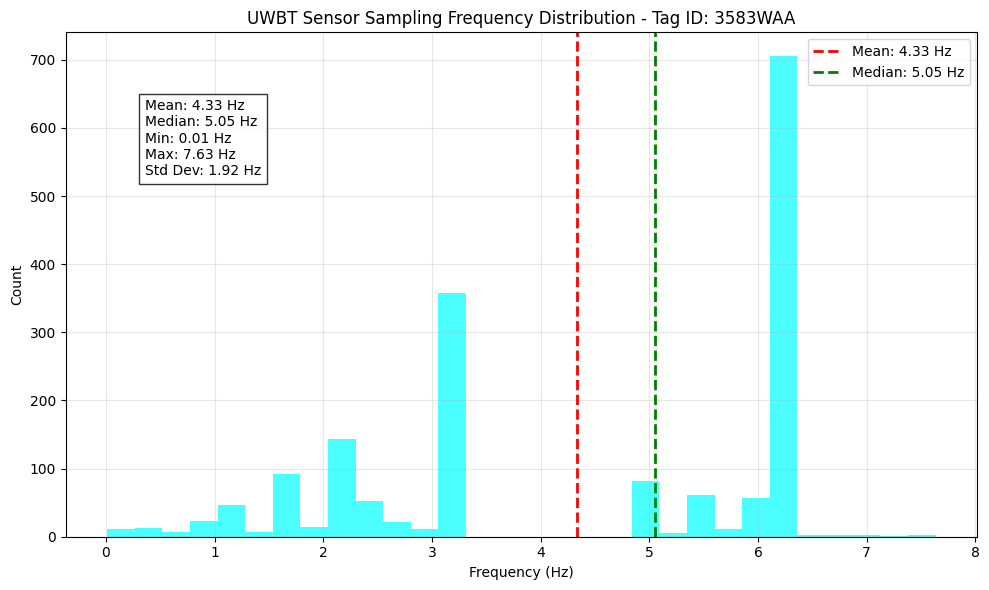

  Creating frequency histogram for tag_id=3636DWF...


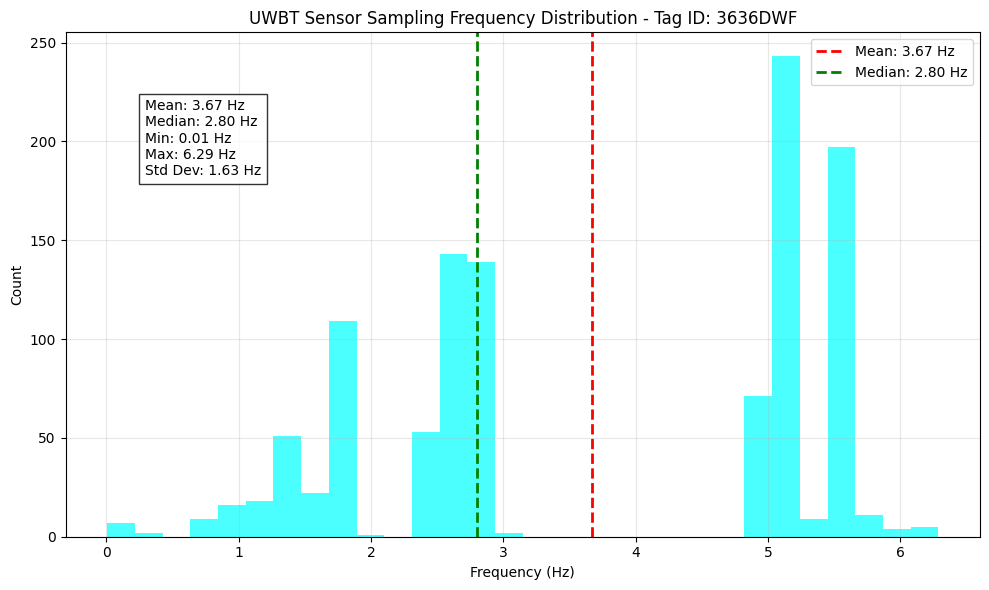

In [9]:
def plot_uwbt_data(df):
    print("Plotting UWBT data...")
    
    # Get unique tag_ids
    unique_tags = df['tag_id'].unique()
    
    for tag_id in unique_tags:
        print(f"  Creating plot for tag_id={tag_id}...")
        
        # Filter data for this tag_id
        tag_df = df[df['tag_id'] == tag_id]
        
        columns_to_plot = ['distance', 'aoa_azimuth', 'aoa_elevation', 'nlos']
        
        fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(12, 2*len(columns_to_plot)))
        fig.suptitle(f'UWBT Data for tag_id={tag_id}', fontsize=16)
        
        axes[0].plot(tag_df.index, tag_df['distance'], 'o', markersize=1.0)
        axes[0].set_ylabel('distance')
        axes[0].grid(True)
        
        axes[1].plot(tag_df.index, tag_df['aoa_azimuth'], 'o', markersize=1.0)
        axes[1].set_ylabel('aoa_azimuth')
        axes[1].grid(True)
        
        axes[2].plot(tag_df.index, tag_df['aoa_elevation'], 'o', markersize=1.0)
        axes[2].set_ylabel('aoa_elevation')
        axes[2].grid(True)
        
        axes[3].plot(tag_df.index, tag_df['nlos'], 'o', markersize=1.0)
        axes[3].set_ylabel('nlos')
        axes[3].grid(True)
        
        axes[-1].set_xlabel('Timestamp (s)')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
        
        
# Plot histogram for UWBT sampling frequency
def plot_uwbt_frequency(df):
    print("Plotting UWBT sampling frequency histogram...")
    
    # Get unique tag_ids
    unique_tags = df['tag_id'].unique()
    
    for tag_id in unique_tags:
        print(f"  Creating frequency histogram for tag_id={tag_id}...")
        
        # Filter data for this tag_id
        tag_df = df[df['tag_id'] == tag_id]
        
        # Calculate frequencies
        frequencies = calculate_frequencies(tag_df.index)
        
        if len(frequencies) == 0:
            print(f"  No frequency data for UWBT with tag_id={tag_id}")
            continue
        
        # Create the histogram
        plt.figure(figsize=(10, 6))
        plt.hist(frequencies, bins=30, alpha=0.7, color='cyan')
        plt.title(f'UWBT Sensor Sampling Frequency Distribution - Tag ID: {tag_id}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)
        
        # Add statistical information
        plt.axvline(np.mean(frequencies), color='red', linestyle='dashed', 
                    linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
        plt.axvline(np.median(frequencies), color='green', linestyle='dashed', 
                    linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
        plt.legend()
        
        # Add text with statistics
        stats_text = f"Mean: {np.mean(frequencies):.2f} Hz\n"
        stats_text += f"Median: {np.median(frequencies):.2f} Hz\n"
        stats_text += f"Min: {np.min(frequencies):.2f} Hz\n"
        stats_text += f"Max: {np.max(frequencies):.2f} Hz\n"
        stats_text += f"Std Dev: {np.std(frequencies):.2f} Hz"
        
        plt.figtext(0.15, 0.7, stats_text, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()


plot_uwbt_data(dataframes['UWBT'])
plot_uwbt_frequency(dataframes['UWBT']) # ignores too much time delta (disconnected duration)
    

### GPOS : Global POSition data
Obtained by the localization system of the AI Suitcase.

Plotting GPOS data...
  Creating plot for object_id=3583WAA...


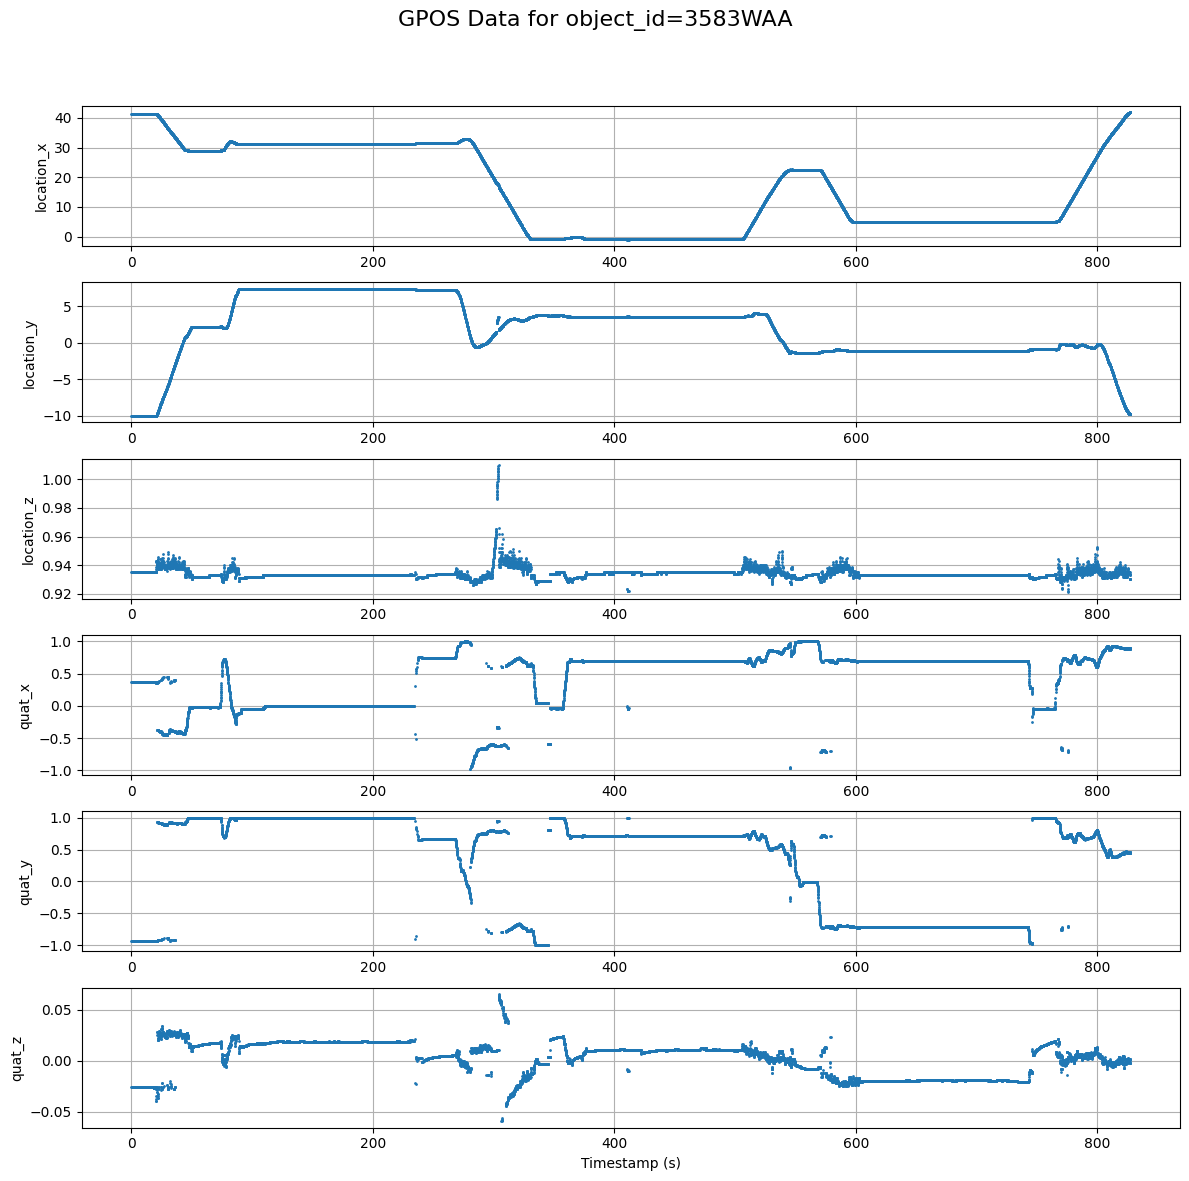

  Creating plot for object_id=3636DWF...


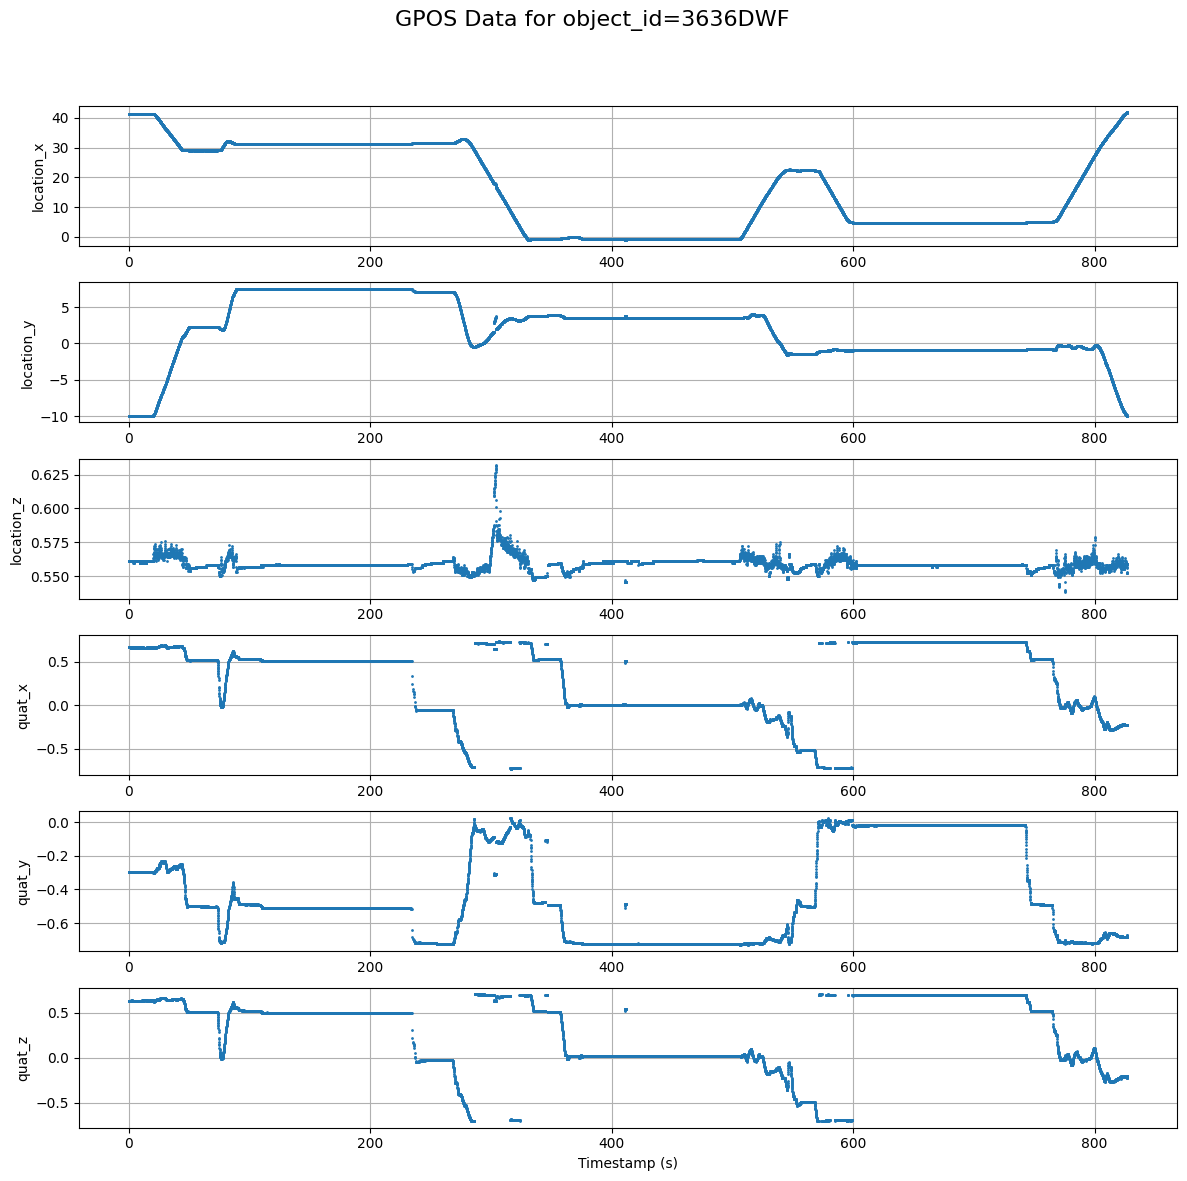

  Creating plot for object_id=3637RLJ...


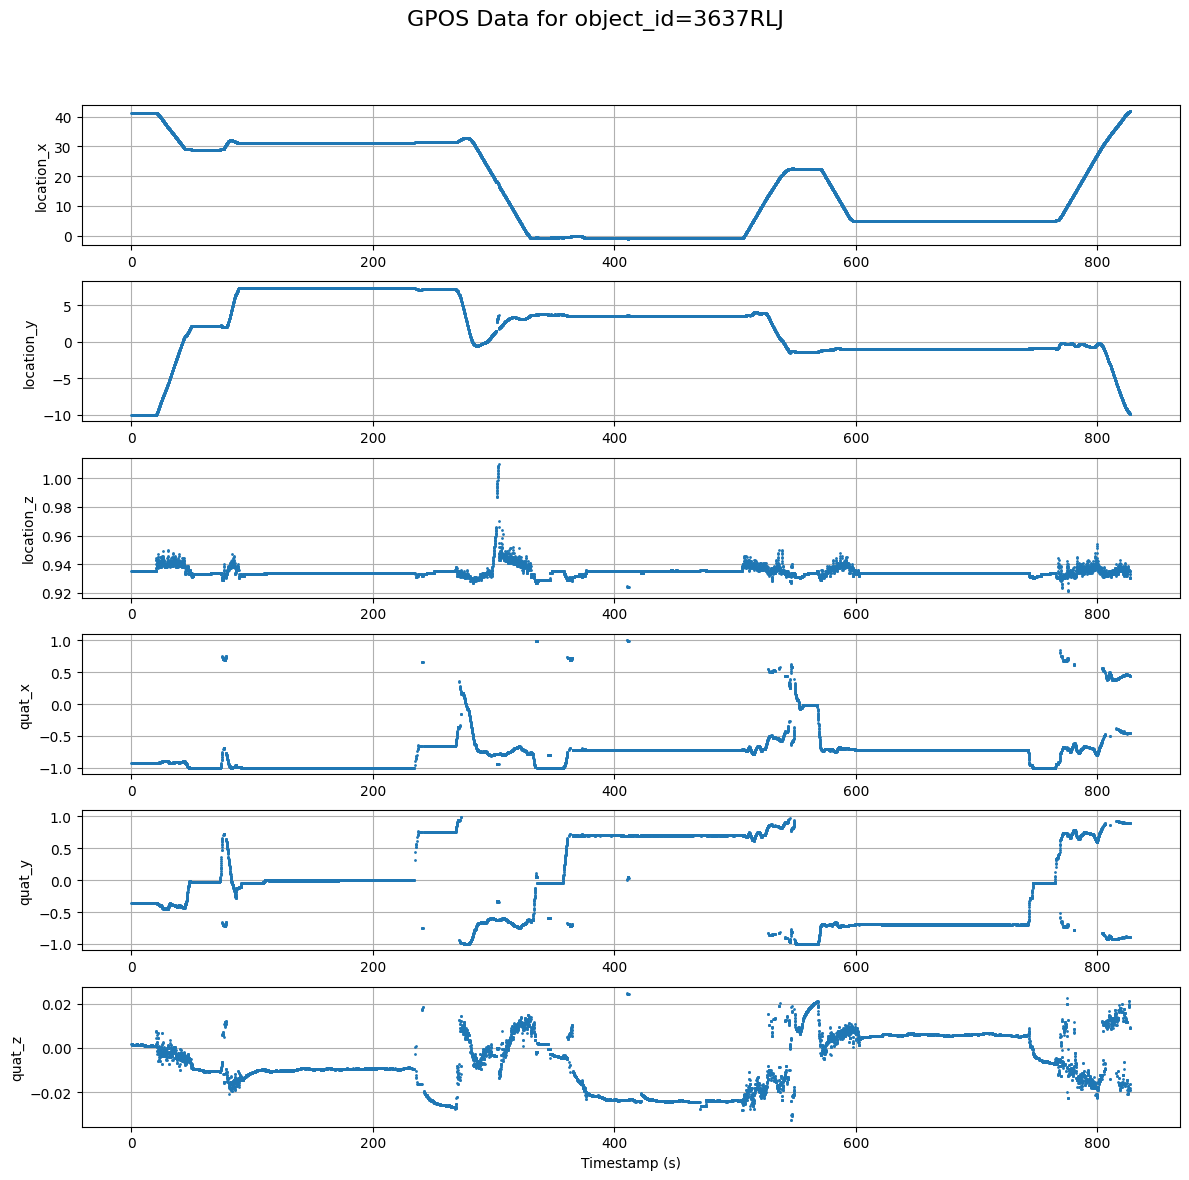

Plotting GPOS sampling frequency histogram...
  Creating frequency histogram for object_id=3583WAA...


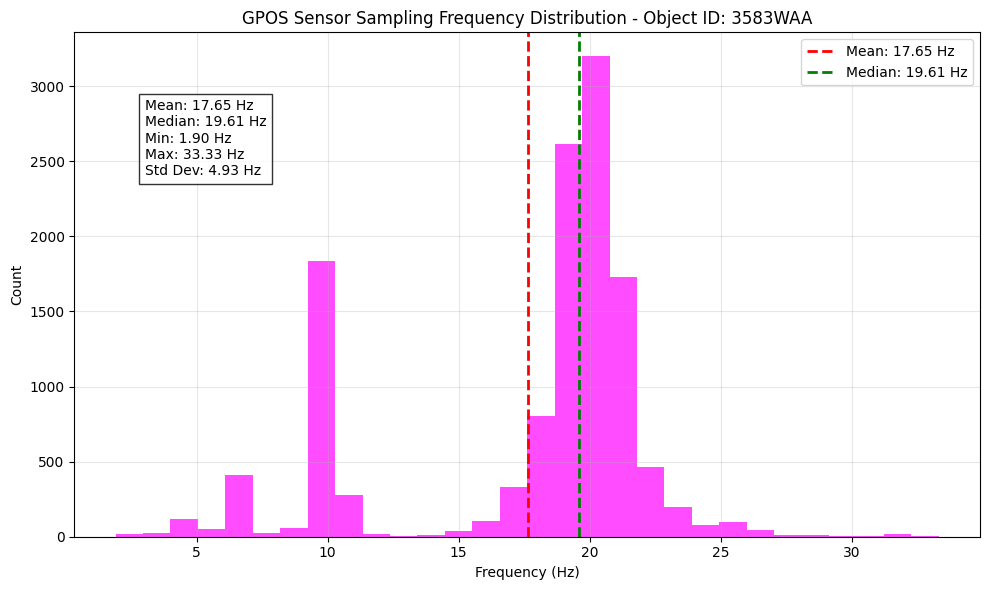

  Creating frequency histogram for object_id=3636DWF...


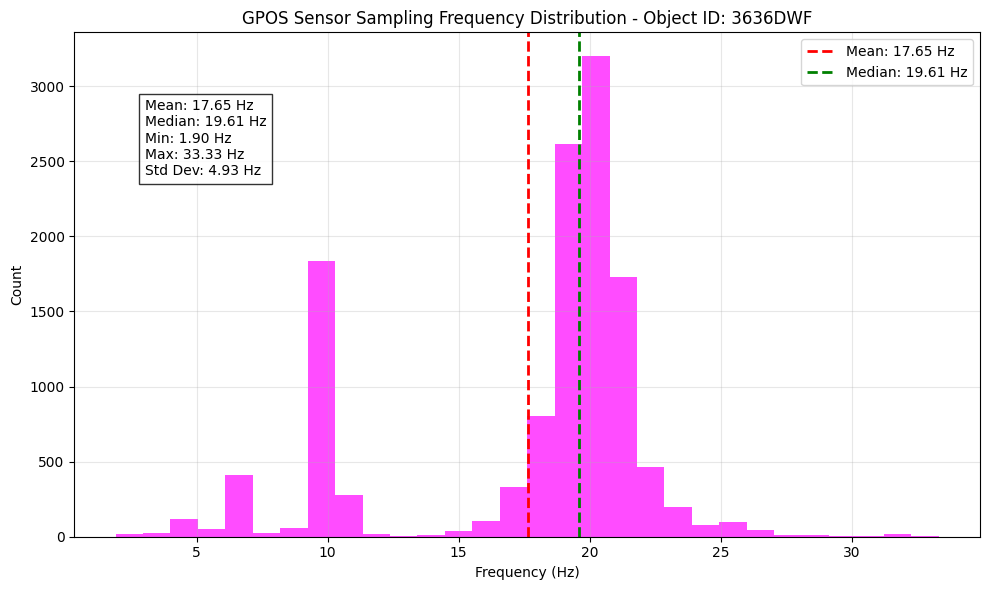

  Creating frequency histogram for object_id=3637RLJ...


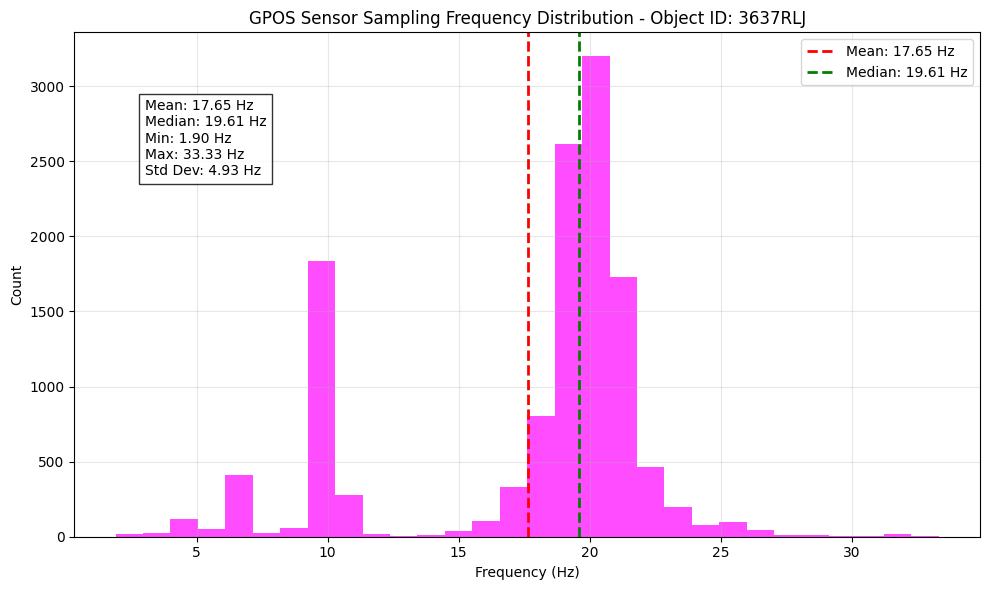

In [10]:
def plot_gpos_data(df):
    print("Plotting GPOS data...")
    
    # Get unique object_ids
    unique_objects = df['object_id'].unique()
    
    for object_id in unique_objects:
        print(f"  Creating plot for object_id={object_id}...")
        
        # Filter data for this object_id
        obj_df = df[df['object_id'] == object_id]
        
        columns_to_plot = ['location_x', 'location_y', 'location_z', 'quat_x', 'quat_y', 'quat_z']
        
        fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(12, 2*len(columns_to_plot)))
        fig.suptitle(f'GPOS Data for object_id={object_id}', fontsize=16)
        
        axes[0].plot(obj_df.index, obj_df['location_x'], 'o', markersize=1.0)
        axes[0].set_ylabel('location_x')
        axes[0].grid(True)
        
        axes[1].plot(obj_df.index, obj_df['location_y'], 'o', markersize=1.0)
        axes[1].set_ylabel('location_y')
        axes[1].grid(True)
        
        axes[2].plot(obj_df.index, obj_df['location_z'], 'o', markersize=1.0)
        axes[2].set_ylabel('location_z')
        axes[2].grid(True)
        
        axes[3].plot(obj_df.index, obj_df['quat_x'], 'o', markersize=1.0)
        axes[3].set_ylabel('quat_x')
        axes[3].grid(True)
        
        axes[4].plot(obj_df.index, obj_df['quat_y'], 'o', markersize=1.0)
        axes[4].set_ylabel('quat_y')
        axes[4].grid(True)
        
        axes[5].plot(obj_df.index, obj_df['quat_z'], 'o', markersize=1.0)
        axes[5].set_ylabel('quat_z')
        axes[5].grid(True)
        
        axes[-1].set_xlabel('Timestamp (s)')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
        
        
def plot_gpos_frequency(df):
    print("Plotting GPOS sampling frequency histogram...")
    
    # Get unique object_ids
    unique_objects = df['object_id'].unique()
    
    for object_id in unique_objects:
        print(f"  Creating frequency histogram for object_id={object_id}...")
        
        # Filter data for this object_id
        obj_df = df[df['object_id'] == object_id]
        
        # Calculate frequencies
        frequencies = calculate_frequencies(obj_df.index)
        
        if len(frequencies) == 0:
            print(f"  No frequency data for GPOS with object_id={object_id}")
            continue
        
        # Create the histogram
        plt.figure(figsize=(10, 6))
        plt.hist(frequencies, bins=30, alpha=0.7, color='magenta')
        plt.title(f'GPOS Sensor Sampling Frequency Distribution - Object ID: {object_id}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)
        
        # Add statistical information
        plt.axvline(np.mean(frequencies), color='red', linestyle='dashed', 
                    linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
        plt.axvline(np.median(frequencies), color='green', linestyle='dashed', 
                    linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
        plt.legend()
        
        # Add text with statistics
        stats_text = f"Mean: {np.mean(frequencies):.2f} Hz\n"
        stats_text += f"Median: {np.median(frequencies):.2f} Hz\n"
        stats_text += f"Min: {np.min(frequencies):.2f} Hz\n"
        stats_text += f"Max: {np.max(frequencies):.2f} Hz\n"
        stats_text += f"Std Dev: {np.std(frequencies):.2f} Hz"
        
        plt.figtext(0.15, 0.7, stats_text, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        

plot_gpos_data(dataframes['GPOS'])
plot_gpos_frequency(dataframes['GPOS'])

### VISO : VISual Odometry

Plotting VISO data...


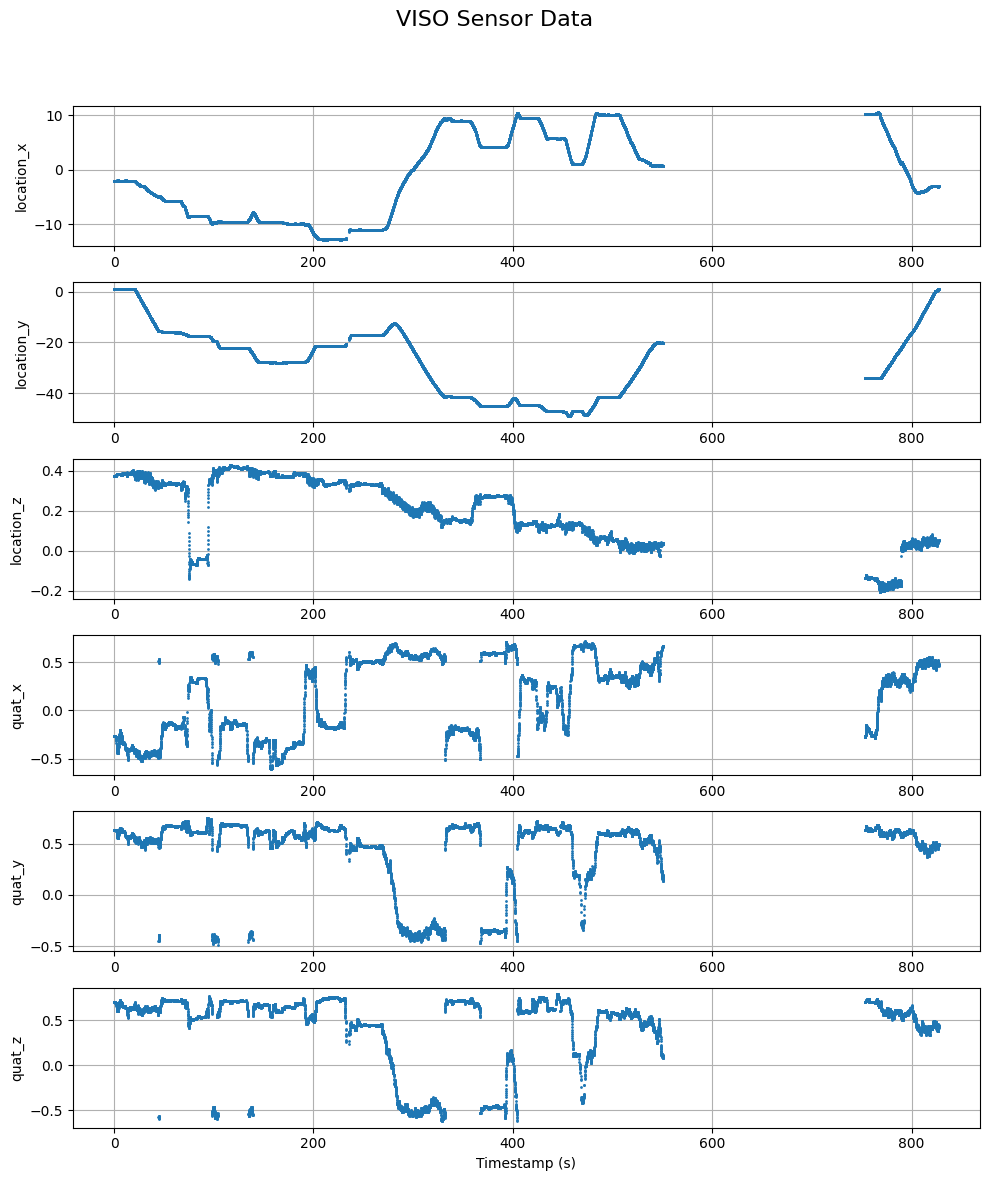

Plotting VISO sampling frequency histogram...


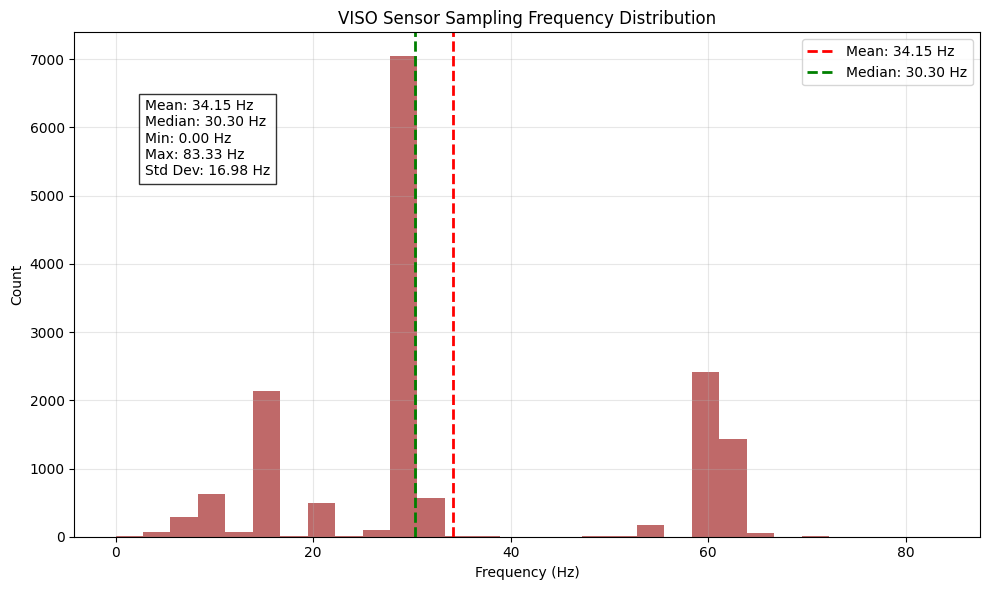

In [11]:
def plot_viso_data(df):
    print("Plotting VISO data...")
    
    columns_to_plot = ['location_x', 'location_y', 'location_z', 'quat_x', 'quat_y', 'quat_z']
    
    fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 2*len(columns_to_plot)))
    fig.suptitle('VISO Sensor Data', fontsize=16)
    
    axes[0].plot(df.index, df['location_x'], 'o', markersize=1.0)
    axes[0].set_ylabel('location_x')
    axes[0].grid(True)
    
    axes[1].plot(df.index, df['location_y'], 'o', markersize=1.0)
    axes[1].set_ylabel('location_y')
    axes[1].grid(True)
    
    axes[2].plot(df.index, df['location_z'], 'o', markersize=1.0)
    axes[2].set_ylabel('location_z')
    axes[2].grid(True)
    
    axes[3].plot(df.index, df['quat_x'], 'o', markersize=1.0)
    axes[3].set_ylabel('quat_x')
    axes[3].grid(True)
    
    axes[4].plot(df.index, df['quat_y'], 'o', markersize=1.0)
    axes[4].set_ylabel('quat_y')
    axes[4].grid(True)
    
    axes[5].plot(df.index, df['quat_z'], 'o', markersize=1.0)
    axes[5].set_ylabel('quat_z')
    axes[5].grid(True)
    
    axes[-1].set_xlabel('Timestamp (s)')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    
def plot_viso_frequency(df):
    print("Plotting VISO sampling frequency histogram...")
    
    # Calculate frequencies
    frequencies = calculate_frequencies(df.index)
    
    if len(frequencies) == 0:
        print("  No frequency data for VISO")
        return
    
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(frequencies, bins=30, alpha=0.7, color='brown')
    plt.title('VISO Sensor Sampling Frequency Distribution')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    
    # Add statistical information
    plt.axvline(np.mean(frequencies), color='red', linestyle='dashed', 
                linewidth=2, label=f'Mean: {np.mean(frequencies):.2f} Hz')
    plt.axvline(np.median(frequencies), color='green', linestyle='dashed', 
                linewidth=2, label=f'Median: {np.median(frequencies):.2f} Hz')
    plt.legend()
    
    # Add text with statistics
    stats_text = f"Mean: {np.mean(frequencies):.2f} Hz\n"
    stats_text += f"Median: {np.median(frequencies):.2f} Hz\n"
    stats_text += f"Min: {np.min(frequencies):.2f} Hz\n"
    stats_text += f"Max: {np.max(frequencies):.2f} Hz\n"
    stats_text += f"Std Dev: {np.std(frequencies):.2f} Hz"
    
    plt.figtext(0.15, 0.7, stats_text, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

    
plot_viso_data(dataframes['VISO'])
plot_viso_frequency(dataframes['VISO'])